In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import gpib
import time
import tqdm
import serial
from IPython.display import clear_output

In [2]:
class YokogawaGS200(object):
	def __init__(self, gpib, addr):
		self.gpib = gpib
		self.addr = addr
		
		self.gpib.addr(self.addr)
		id = self.gpib('*idn?', True)
		if not id.startswith('YOKOGAWA,GS2'):
			raise ValueError('Device identifies as ' + id)

	def output(self, on):
		self.gpib.addr(self.addr)
		if on:
			self.gpib(':OUTP 1')
		else:
			self.gpib(':OUTP 0')

	def voltage_mode(self):
		self.gpib.addr(self.addr)
		self.gpib(':SOUR:FUNC VOLT')

	def current_mode(self):
		self.gpib.addr(self.addr)
		self.gpib(':SOUR:FUNC CURR')

	def set_range(self, range):
		''' Valid values are .001, .01, .1, .2, 1, 10, 30 '''
		self.gpib.addr(self.addr)

		if range < 1:
			self.gpib(':SOUR:RANG %dE-3' % (range*1000))
		else:
			self.gpib(':SOUR:RANG %dE+0' % range)

		newrange = self.gpib(':SOUR:RANG?', True)
		if float(newrange) != range:
			raise ValueError('GS200 did not accept request for range %f, returned %s' % (range, newrange))
		return newrange

	def set_level(self, level):
		self.gpib.addr(self.addr)
		self.gpib(':SOUR:LEV %f' % level)

class Keysight34420A(object):
	def __init__(self, gpib, addr):
		self.gpib = gpib
		self.addr = addr
		
		self.gpib.addr(self.addr)
		id = self.gpib('*idn?', True)
		if not id.startswith('HEWLETT-PACKARD,34420A'):
			raise ValueError('Device identifies as ' + id)
		self.gpib.auto_rw(True)

	def get_value(self, range='AUTO', channel=1):
		''' Gets the value before this command, then triggers an update for the next call '''
		self.gpib.addr(self.addr)
		response = self.gpib('MEAS:VOLT:DC?', True)
		return float(response)

class Kiethley196(object):
	def __init__(self, gpib, addr):
		self.gpib = gpib
		self.addr = addr
		
		self.gpib.addr(self.addr)
		id = self.gpib('', True)
		if not id.startswith('N'):
			raise ValueError('Unexpected device response ' + id)

	def dc_volts(self):
		self.gpib.addr(self.addr)
		self.gpib('F0X', True)
	def ac_volts(self):
		self.gpib.addr(self.addr)
		self.gpib('F1X', True)
	def dc_amps(self):
		self.gpib.addr(self.addr)
		self.gpib('F3X', True)
	def ac_amps(self):
		self.gpib.addr(self.addr)
		self.gpib('F4X', True)
	def ohms(self):
		self.gpib.addr(self.addr)
		self.gpib('F2X', True)
	def range(self, range):
		'''Set range to a value in 0-7. 0 is AUTO, while higher numbers are 3 * 10^(x0 + range), with x0 = -4 for voltages, -7 for current, and +1 for resistance. '''
		self.gpib.addr(self.addr)
		self.gpib('F%dX' % range, True)
	def get_value(self):
		self.gpib.addr(self.addr)
		rval = self.gpib('', True)
		bk = rval.find('+')
		if bk < 0 or (0 < rval.find('-') < bk):
			bk = rval.find('-')
		return (float(rval[bk:]), rval[1:bk])

In [3]:
class LakeShore211:
    def __init__(self, port, baudrate=9600, timeout=1):
        """
        Initialize the connection to the Lake Shore Model 211 temperature monitor.

        :param port: The serial port to which the device is connected (e.g., 'COM3', '/dev/ttyUSB0').
        :param baudrate: The baud rate for the serial communication (default is 9600).
        :param timeout: The timeout for serial communication in seconds (default is 1 second).
        """
        self.port = port
        self.baudrate = baudrate
        self.timeout = timeout
        self.serial_connection = None
        
        self.connect()

    def connect(self):
        """Establish a connection to the device."""
        self.serial_connection = serial.Serial(
            port=self.port,
            baudrate=self.baudrate,      # e.g. 9600
            bytesize=serial.SEVENBITS,    # 7 data bits
            parity=serial.PARITY_EVEN,    # even parity
            stopbits=serial.STOPBITS_ONE, # 1 stop bit
            timeout=self.timeout
        )
        if self.serial_connection.is_open:
            print(f"Connected to Lake Shore 211 on {self.port}")
        else:
            raise ConnectionError("Failed to open serial connection.")

    def disconnect(self):
        """Close the connection to the device."""
        if self.serial_connection and self.serial_connection.is_open:
            self.serial_connection.close()
            print("Disconnected from Lake Shore 211.")

    def send_command(self, command):
        """
        Send a command to the device.

        :param command: The command string to send (e.g., 'KRDG?').
        """
        if not self.serial_connection or not self.serial_connection.is_open:
            raise ConnectionError("Serial connection is not open.")
        self.serial_connection.write((command + '\r\n').encode('ascii'))

    def read_response(self):
        """
        Read the response from the device.

        :return: The response string from the device.
        """
        if not self.serial_connection or not self.serial_connection.is_open:
            raise ConnectionError("Serial connection is not open.")
        response = self.serial_connection.readline().decode('ascii').strip()
        return response

    def get_temperature(self):
        """
        Get the current temperature reading from the device.

        :return: The temperature value as a float.
        """
        self.send_command('KRDG?')
        response = self.read_response()
        try:
            return float(response)
        except ValueError:
            raise ValueError(f"Invalid response received: {response}")

In [4]:
ls = LakeShore211('COM4')
ls.send_command("*IDN?")
print(ls.read_response())

ls.send_command("KRDG?")
print(ls.read_response())

ls.get_temperature()

Connected to Lake Shore 211 on COM4
LSCI,MODEL211,LSA26IE,041218
+295.34


295.34

In [5]:
gpibint = gpib.PrologixGPIB('COM3')
yk = YokogawaGS200(gpibint, 1) # POWER SUPPLY
dvm = Keysight34420A(gpibint, 23) # VOLT METER
#dmm = Kiethley196(gpibint, 9) # 2ND VOLT METER
yk.current_mode()
yk.set_range(0.1)
yk.set_level(0.0)
yk.output(True)

In [6]:
def measure_current(current_mA, sleep_time=0.1):
    ranges = np.array([0.001, 0.01, 0.1, 0.2, 1, 10, 30])
    ranges = ranges[ranges >= current_mA / 1000.0]
    if len(ranges) == 0:
        raise ValueError('Current %f is out of range' % current_mA)
    yk.set_range(ranges[0])
    
    yk.set_level(current_mA / 1000.0)
    time.sleep(sleep_time)
    try:
        return dvm.get_value()
    except KeyboardInterrupt:
        print('Keyboard interrupt')
        sys.exit(0)
    except:
        print('Error reading DVM')
        return None
    finally:
        yk.set_level(0.0)

In [7]:
def plot_IVTt(I, V, T, t):
    clear_output(wait=True)
    plt.figure(figsize=(12, 8))
    
    plt.subplot(221) # IV plot
    plt.scatter(I, V, c=T, cmap='plasma')
    plt.plot(I, V, color='k', alpha=0.5) # Line plot for better visibility
    plt.colorbar(label='Temperature (K)')
    plt.xlabel('Current (mA)')
    plt.ylabel('Voltage (V)')
    plt.title('IV Curve')
    plt.grid(True)
    
    plt.subplot(222) # Resistance plot
    R1 = np.diff(V) / np.diff(I) * 1000
    R2 = np.array(V) / np.array(I) * 1000
    
    plt.plot(I[1:], R1, label='dV/dI')
    plt.plot(I, R2, label='V/I')
    plt.xlabel('Current (mA)')
    plt.ylabel('Resistance (Ohm)')
    plt.title('Resistance vs Current')
    plt.legend()
    
    plt.subplot(223) # Temperature plot
    plt.plot(t, T, label='Temperature')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.title('Temperature vs Time')
    
    plt.show()

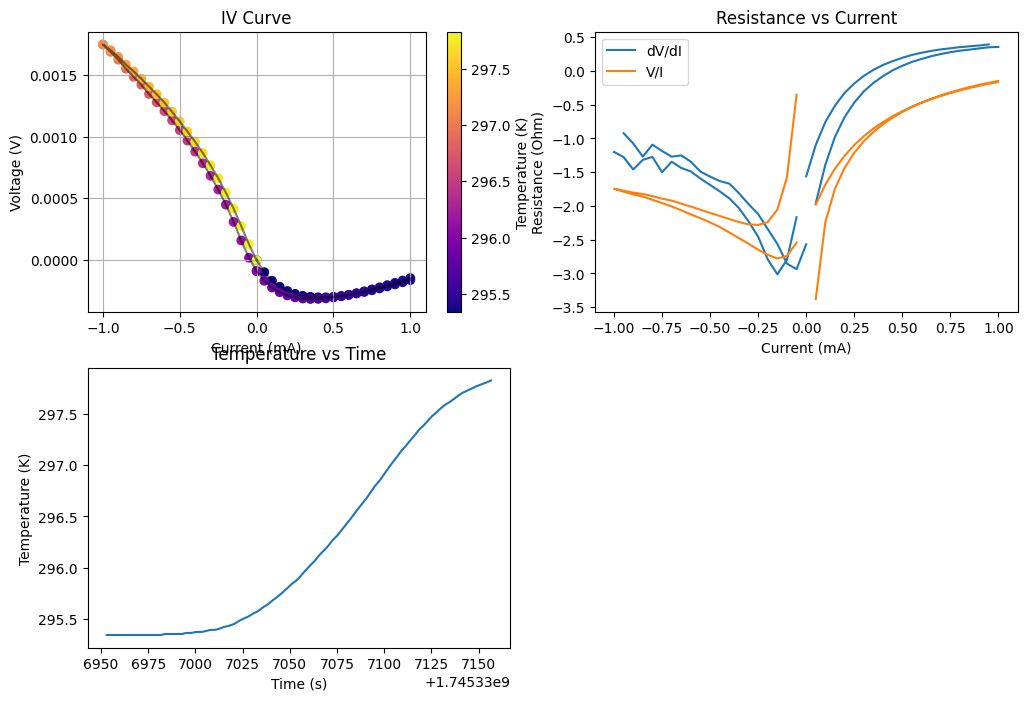

100%|██████████| 84/84 [03:26<00:00,  2.46s/it]


In [8]:
max_current = 1 # mA
current_step = 0.05 # mA


# positive and negative current sweeps
currents = np.arange(0, max_current + current_step, current_step)
currents = np.append(currents, currents[::-1])
currents = np.append(currents, -1 * currents)

output_file = f'{time.strftime('%Y%m%d%H%M%S', time.localtime())}.csv'
IVTt = [[],[],[],[]]
with open(output_file, 'w') as f:
    f.write('Current (mA),Voltage (V),Temperature (K),Time (s)\n')
    
    for current_mA in tqdm.tqdm(currents):
        voltage = measure_current(current_mA)
        if voltage is None:
            continue
        temperature = ls.get_temperature()
        now_time = time.time()
        
        f.write(f'{current_mA}, {voltage}, {temperature}, {now_time}\n')
        IVTt[0].append(current_mA)
        IVTt[1].append(voltage)
        IVTt[2].append(temperature)
        IVTt[3].append(now_time)
        
        f.flush()
        plot_IVTt(IVTt[0], IVTt[1], IVTt[2], IVTt[3])

C:\Users\Adam\AppData\Local\Temp\ipykernel_9804\788702071.py:15: RuntimeWarning: divide by zero encountered in divide
  R1 = np.diff(V) / np.diff(I) * 1000
C:\Users\Adam\AppData\Local\Temp\ipykernel_9804\788702071.py:16: RuntimeWarning: divide by zero encountered in divide
  R2 = np.array(V) / np.array(I) * 1000


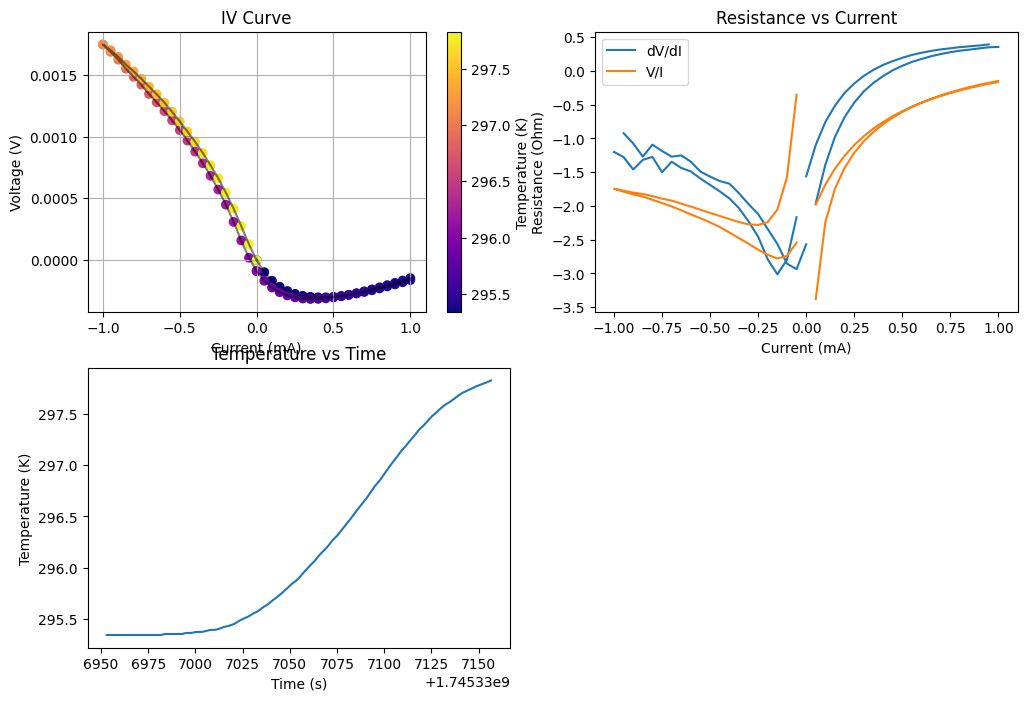

In [9]:
plot_IVTt(IVTt[0], IVTt[1], IVTt[2], IVTt[3])